In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
nan_cols = test.isna().sum()
test1 = test.drop(nan_cols[nan_cols > 269].index.tolist(), axis = 1)
train1 = train.drop(nan_cols[nan_cols > 269].index.tolist(), axis = 1)

In [4]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)

# fit and transform the data
test_imputed = pd.DataFrame(imputer.fit_transform(test1), columns=test1.columns)
train_imputed = pd.DataFrame(imputer.fit_transform(train1), columns=train1.columns)

In [5]:
corr_matrix = train_imputed.corr().abs()

In [6]:
corr_y = train_imputed.corrwith(train_imputed['y'])
train_imputed.drop(corr_y[corr_y.isna()].index.tolist(), axis = 1, inplace = True)
test_imputed.drop(corr_y[corr_y.isna()].index.tolist(), axis = 1, inplace = True)

In [7]:
# identify predictors that have correlation of >0.7
indices = np.where(np.triu(corr_matrix > 0.7, k=1))

# print the pairs of columns that have a correlation > 0.7
high_corr = []
count = 0
for idx in range(len(indices[0])):
    col1 = corr_matrix.columns[indices[0][idx]]
    col2 = corr_matrix.columns[indices[1][idx]]
    high_corr.append(col1)
    count+=1
    #print(f"{col1} and {col2}")
#print(count)

In [8]:
unique_vals = set(high_corr)
train_imputed = train_imputed.drop(unique_vals, axis = 1)

In [9]:
test_col = train_imputed.drop('y', axis = 1)
test_imputed = test_imputed[test_col.columns]

In [12]:
corr_y = train_imputed.corrwith(train_imputed['y'])
top_30 = corr_y.abs().sort_values(ascending = False)[1:31]

In [13]:
top_30.index

Index(['x755', 'x756', 'x685', 'x724', 'x662', 'x447', 'x734', 'x684', 'x710',
       'x111', 'x274', 'x740', 'x716', 'x718', 'x400', 'x745', 'x680', 'x750',
       'x634', 'x741', 'x500', 'x723', 'x699', 'x473', 'x211', 'x043', 'x395',
       'x736', 'x623', 'x693'],
      dtype='object')

In [14]:
X = train_imputed[top_30.index.tolist()]
y = train_imputed.y
X_test = test_imputed[top_30.index.tolist()]

In [15]:
### No. of trees vs. cross validation error

>5 10.621 (0.584)
>10 10.543 (0.486)
>50 10.794 (0.487)
>100 10.901 (0.471)
>500 10.965 (0.484)
>1000 10.965 (0.485)
>2000 10.965 (0.485)
>5000 10.965 (0.485)


Text(0.5, 0, 'Number of trees')

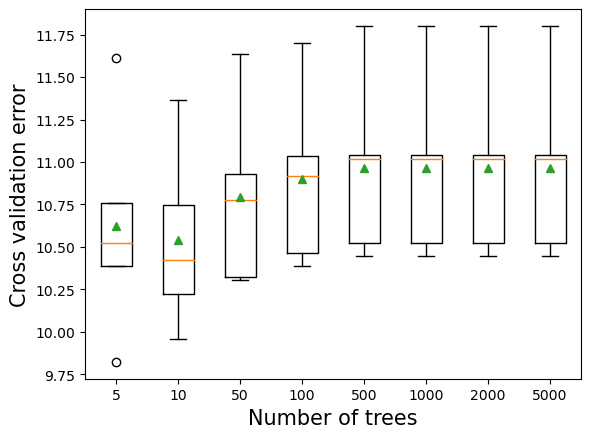

In [14]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [5, 10, 50, 100, 500, 1000, 2000, 5000]
    for n in n_trees:
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

### Learning rate vs. cross validation error

>0.0100 10.9 (1.6)
>0.0500 10.2 (1.3)
>0.1000 10.3 (1.3)
>0.2000 10.5 (1.3)
>0.3000 10.7 (1.1)
>0.4000 11.2 (1.2)
>0.5000 11.6 (1.2)
>0.6000 11.8 (1.0)
>0.8000 12.3 (1.0)
>1.0000 13.5 (0.9)


Text(0.5, 0, 'Learning rate')

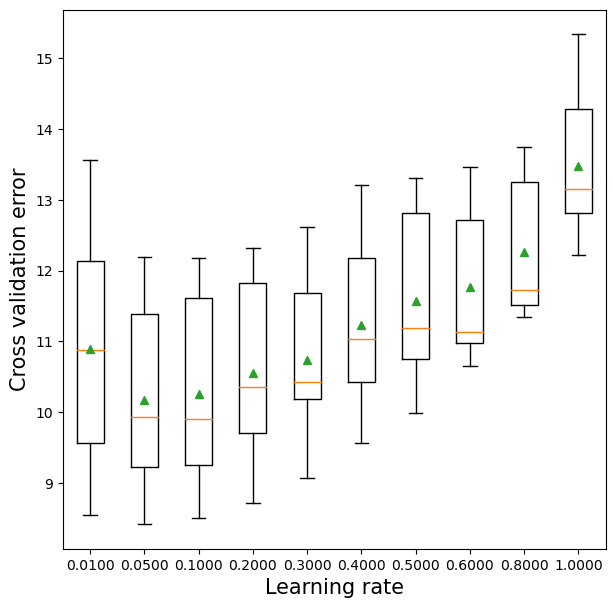

In [17]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

### Regularization vs. cross validation error 

>0.0000 11.2 (1.1)
>0.5000 10.9 (1.0)
>1.0000 10.7 (1.1)
>1.5000 10.7 (1.2)
>2.0000 10.6 (1.4)
>10.0000 10.7 (1.3)
>100.0000 10.5 (1.2)


Text(0.5, 0, 'reg_lambda')

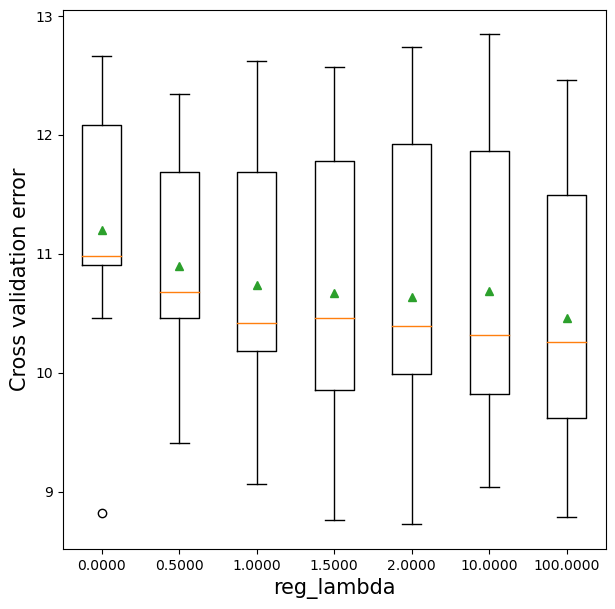

In [18]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0,0.5,1.0,1.5,2,10,100]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

### Regularization (gamma) vs. cross validation error

>0.0000 10.7 (1.1)
>10.0000 10.8 (1.2)
>100.0000 10.6 (1.3)
>1000.0000 10.4 (1.2)
>10000.0000 10.5 (1.4)
>100000.0000 11.9 (1.7)
>1000000.0000 11.9 (1.7)
>10000000.0000 11.9 (1.7)
>100000000.0000 11.9 (1.7)
>1000000000.0000 11.9 (1.7)


Text(0.5, 0, 'gamma')

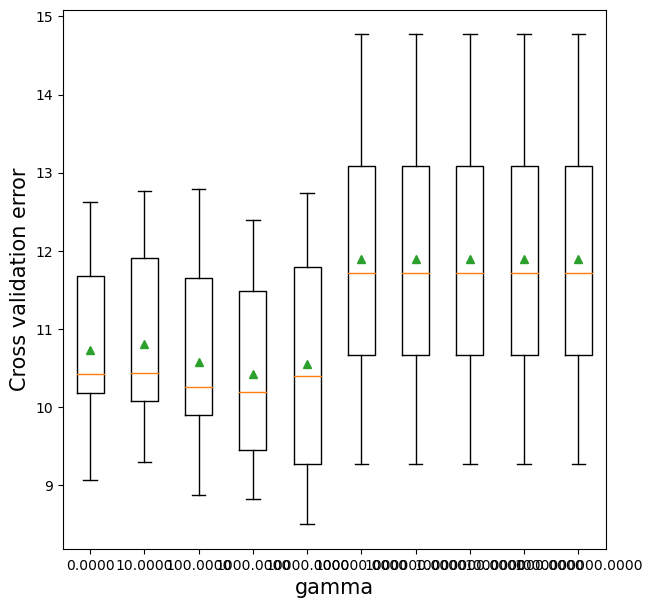

In [19]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(gamma=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('gamma',fontsize=15)

### Tuning XGboost regressor

In [21]:
#K-fold cross validation to find optimal parameters for XGBoost
start_time = time.time()
param_grid = {'max_depth': [5,6,7],
              'learning_rate': [0.01,0.05,0.1,0.2],
               'reg_lambda':[0,0.01,0.001],
                'n_estimators':[150,175,250,500,1000]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,                             
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X,y)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", (time.time()-start_time)/60, " minutes")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Optimal parameter values = {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'reg_lambda': 0}
Optimal cross validation R-squared =  0.2723486267149203
Time taken =  116.89041006565094  minutes


In [22]:
cv_results=pd.DataFrame(optimal_params.cv_results_)
cv_results.sort_values(by = 'mean_test_score',ascending=False)[1:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
45,7.529998,2.968267,0.016086,0.005688,0.05,5,150,0,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.312037,0.194465,0.223778,0.248477,0.379746,0.271701,0.066486,2
11,16.805838,0.239482,0.035331,0.011213,0.01,5,500,0.001,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.300384,0.202781,0.228180,0.243932,0.375489,0.270153,0.061641,3
47,4.961077,0.220659,0.014725,0.003232,0.05,5,150,0.001,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.314503,0.196744,0.211412,0.246727,0.378765,0.269630,0.068044,4
48,6.506721,0.187468,0.026042,0.017705,0.05,5,175,0,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.317490,0.186919,0.219610,0.242890,0.376552,0.268692,0.068959,5


In [15]:
model = xgb.XGBRegressor(random_state=1,max_depth=6,n_estimators=1000,
                                         learning_rate = 0.01,reg_lambda=0.01)
model.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

In [17]:
pred = pd.DataFrame()
pred['id'] = test['id']
pred['y'] = model.predict(X_test)
pred = pred.set_index(['id'])
pred.to_csv('Witarsa_Ashley_regression.csv') 